## Understanding Meta-Learners in CausalML


This notebook provides an overview of meta-learners available in the CausalML library for estimating heterogeneous treatment effects, specifically the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE). Meta-learners are methods that leverage machine learning models to estimate causal effects, allowing for flexible modeling of treatment effect heterogeneity. We'll cover the main meta-learners implemented in CausalML, their theoretical basis, strengths, weaknesses, and provide practical examples using synthetic data.

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner, BaseRLearner
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 1000
X = np.random.normal(0, 1, (n_samples, 3))  # 3 features
treatment = np.random.binomial(1, 0.5, n_samples)  # Binary treatment
true_ate = 2.0  # True average treatment effect
y = 3 * X[:, 0] + 2 * X[:, 1] - X[:, 2] + true_ate * treatment + np.random.normal(0, 0.5, n_samples)

# Convert to DataFrame for convenience
data = pd.DataFrame(X, columns=['X1', 'X2', 'X3'])
data['treatment'] = treatment
data['outcome'] = y

# Split features, treatment, and outcome
X = data[['X1', 'X2', 'X3']].values
treatment = data['treatment'].values
y = data['outcome'].values

## S_Learner

Overview
The S-Learner (Single Learner) uses a single machine learning model to predict the outcome, including the treatment indicator as a feature alongside other covariates. The CATE is estimated as the difference in predictions when setting the treatment indicator to 1 versus 0.

Steps:
Train a model to predict ( Y ) using features ( X ) and treatment ( T ): ( \hat{\mu}(X, T) ).

Estimate CATE as: ( \hat{\tau}(X) = \hat{\mu}(X, 1) - \hat{\mu}(X, 0) ).

Pros:
Simple and computationally efficient.
Can handle continuous and discrete treatments.
Works well when treatment effect is not the dominant factor.
Cons:

May bias treatment effects toward zero due to regularization in the model.
Can ignore treatment if it's a weak predictor compared to other features.

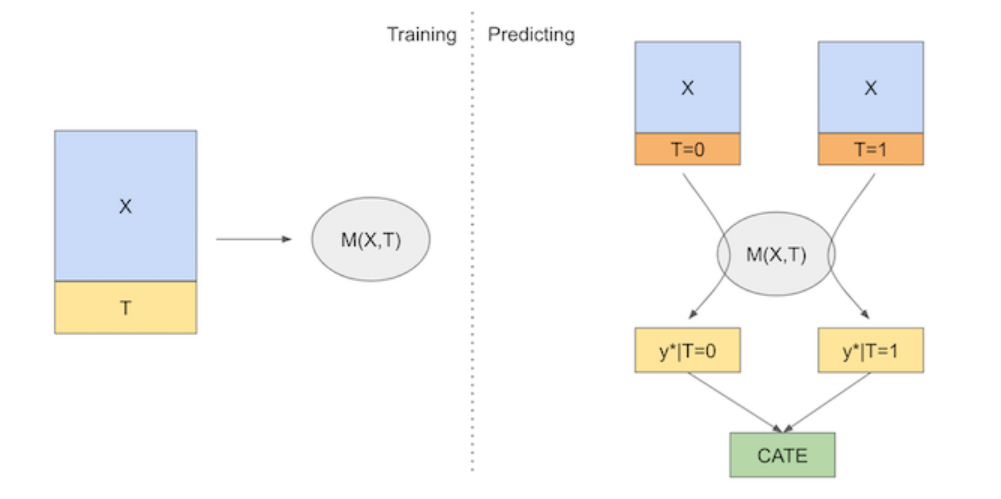

S-Learner ATE: 2.069


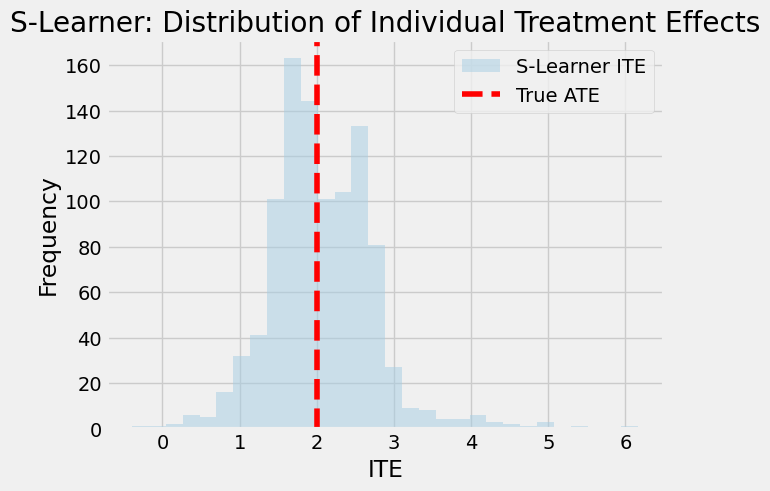

In [10]:
## With causal ML library

# Initialize S-Learner with Gradient Boosting
s_learner = BaseSLearner(learner=GradientBoostingRegressor(random_state=42))

# Fit the model
s_learner.fit(X=X, treatment=treatment, y=y)

# Estimate CATE
s_learner_cate = s_learner.estimate_ate(X=X, treatment=treatment, y=y)

# Predict individual treatment effects
s_ite = s_learner.predict(X)

# Print ATE
print(f'S-Learner ATE: {s_learner_cate[0]:.3f}')

# Plot distribution of ITE
plt.hist(s_ite, bins=30, alpha=0.5, label='S-Learner ITE')
plt.axvline(true_ate, color='red', linestyle='--', label='True ATE')
plt.title('S-Learner: Distribution of Individual Treatment Effects')
plt.xlabel('ITE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## T-Learner

Overview
The T-Learner (Two Learner) trains separate models for the treatment and control groups. It estimates the outcome for treated (( Y(1) )) and control (( Y(0) )) groups and computes the CATE as their difference.

Steps:

Split data into treatment (( T=1 )) and control (( T=0 )) groups.
Train a model for each group: ( \hat{\mu}_1(X) ) for treated, ( \hat{\mu}_0(X) ) for control.
Estimate CATE as: ( \hat{\tau}(X) = \hat{\mu}_1(X) - \hat{\mu}_0(X) ).
Pros:

Explicitly models differences between treatment and control groups.
Avoids bias toward zero seen in S-Learner.
Cons:

Requires sufficient data in both treatment and control groups.
Can be sensitive to model misspecification.
Only handles discrete treatments.

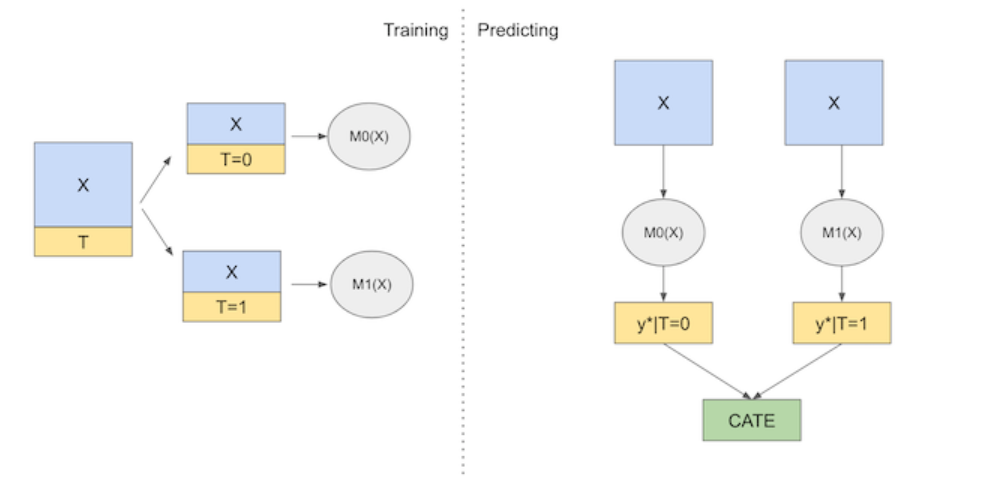

T-Learner ATE: 1.992


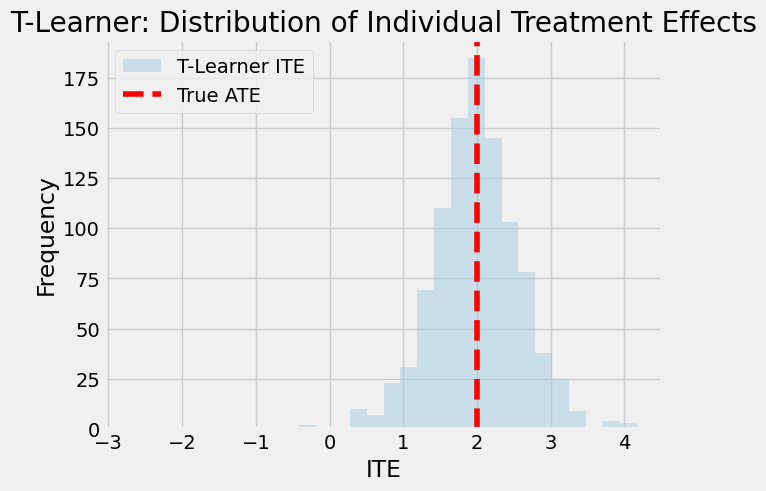

In [ ]:
## With Causal-ML library

# Initialize T-Learner with Gradient Boosting
t_learner = BaseTLearner(learner=GradientBoostingRegressor(random_state=42))

# Fit the model
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate CATE
t_learner_cate = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

# Predict individual treatment effects
t_ite = t_learner.predict(X)

# Print ATE
# Ensure t_learner_cate[0] is a scalar
ate = t_learner_cate[0].item() if isinstance(t_learner_cate[0], np.ndarray) else t_learner_cate[0]
print(f'T-Learner ATE: {ate:.3f}')

# Plot distribution of ITE
plt.hist(t_ite, bins=30, alpha=0.5, label='T-Learner ITE')
plt.axvline(true_ate, color='red', linestyle='--', label='True ATE')
plt.title('T-Learner: Distribution of Individual Treatment Effects')
plt.xlabel('ITE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## X_learners

X-learners are a type of meta-learner used in causal inference to estimate heterogeneous treatment effects, specifically the Conditional Average Treatment Effect (CATE). They are designed to improve upon earlier meta-learners like T-learners and S-learners by addressing their limitations, particularly in handling imbalanced treatment assignments or complex, non-linear relationships in data. Below, I’ll explain X-learners in a clear and structured way, assuming a general understanding of machine learning and causal inference concepts.

### What Are Meta-Learners?
Meta-learners are frameworks that use standard machine learning models (e.g., regression, tree-based models, or neural networks) to estimate treatment effects in observational data studies or randomized experiments. They decompose the problem of estimating CATE—the effect of a treatment on an outcome conditional on covariates—into subproblems that can be solved with supervised learning. Common meta-learners include S-learners, T-learners, and X-learners.

### What Is an X-Learner?
The X-learner is a meta-learner introduced by Künzel et al. (2019) to estimate CATE more accurately, particularly when treatment and control groups are imbalanced or when the treatment effect varies significantly across subgroups. It combines the strengths of T-learners and propensity score weighting to produce robust and flexible estimates.

The X-learner works in three main stages:
1. **Estimate Outcome Models for Treatment and Control Groups** (like a T-learner).
2. **Impute Treatment Effects** for each individual.
3. **Estimate CATE** by modeling the imputed treatment effects as a function of covariates.

### How X-Learners Work
Here’s a step-by-step explanation of the X-learner algorithm:

1. **Stage 1: Fit Outcome Models**
   - Split the data into treatment (W=1) and control (W=0) groups, where W is the treatment indicator.
   - Train a machine learning model to predict the outcome (Y) for the treatment group based on covariates (X), yielding a model \(\mu_1(X)\).
   - Train another model to predict the outcome for the control group based on covariates, yielding \(\mu_0(X)\).
   - These models estimate the expected outcomes \(E[Y|X, W=1]\) and \(E[Y|X, W=0]\), respectively.

2. **Stage 2: Impute Treatment Effects**
   - For each individual in the treatment group, compute the imputed treatment effect:
     \[
     D_i^1 = Y_i - \mu_0(X_i)
     \]
     This represents the observed outcome minus the predicted outcome under the control condition.
   - For each individual in the control group, compute the imputed treatment effect:
     \[
     D_i^0 = \mu_1(X_i) - Y_i
     \]
     This represents the predicted outcome under treatment minus the observed control outcome.
   - These imputed effects approximate the individual treatment effect for each observation.

3. **Stage 3: Estimate CATE**
   - Train two separate models to predict the imputed treatment effects:
     - For the treatment group, regress \(D_i^1\) on \(X_i\) to get a model \(\tau_1(X)\).
     - For the control group, regress \(D_i^0\) on \(X_i\) to get a model \(\tau_0(X)\).
   - Combine these models to estimate the CATE, \(\tau(X) = E[Y(1) - Y(0)|X]\), using a weighted average:
     \[
     \tau(X) = g(X) \cdot \tau_0(X) + (1 - g(X)) \cdot \tau_1(X)
     \]
     where \(g(X)\) is a weighting function, often the propensity score \(P(W=1|X)\) or its inverse, to balance the contributions of the two models. If the propensity score is not used, \(g(X)\) can be a constant (e.g., 0.5) or estimated via cross-validation.

4. **Optional: Propensity Score Adjustment**
   - The propensity score \(P(W=1|X)\) can be estimated using a separate model to account for selection bias in observational data studies. This is particularly useful when treatment assignment is not random.
   - The propensity score can be used in the weighting step or to reweight the imputed treatment effects in Stage 2.

### Advantages of X-Learners
- **Handles Imbalanced Data**: X-learners perform well when the treatment and control groups have different sizes or characteristics, as they model the treatment effect separately for each group and combine them intelligently.
- **Flexibility**: They can use any machine learning model (e.g., random forests, neural networks) for both outcome prediction and CATE estimation, making them adaptable to complex data.
- **Robustness**: By imputing treatment effects and modeling them separately, X-learners can capture heterogeneity in treatment effects more effectively than T-learners or S-learners.
- **Propensity Score Integration**: The use of propensity scores in the weighting step helps address confounding in observational data.

### Limitations of X-Learners
- **Complexity**: X-learners are more computationally intensive than simpler meta-learners like S-learners or T-learners due to the multiple modeling stages.
- **Dependence on Model Quality**: The accuracy of X-learners relies on the quality of the outcome models (\(\mu_1(X)\), \(\mu_0(X)\)) and the CATE models (\(\tau_1(X)\), \(\tau_0(X)\)). Poorly fitted models can lead to biased estimates.
- **Propensity Score Estimation**: In observational studies, accurate estimation of the propensity score is critical. Misspecification can introduce bias.

### Comparison with Other Meta-Learners
- **S-Learner**: Treats the treatment indicator as a covariate and fits a single model to predict the outcome. It can miss complex treatment effect heterogeneity and is less effective when treatment effects vary significantly.
- **T-Learner**: Fits separate models for the treatment and control groups (like Stage 1 of X-learners) and estimates CATE as \(\mu_1(X) - \mu_0(X)\). It can perform poorly with imbalanced data or when one group’s model is less accurate.
- **X-Learner**: Improves on T-learners by imputing treatment effects and modeling them separately, then combining them with weights. This makes it more robust to imbalances and model misspecification.

### Practical Considerations
- **When to Use X-Learners**: X-learners are particularly useful in scenarios with imbalanced treatment groups, complex treatment effect heterogeneity, or when you have a large dataset that allows robust modeling of both outcome and treatment effect functions.
- **Implementation**: X-learners can be implemented using standard machine learning libraries (e.g., scikit-learn, XGBoost) for the regression tasks. Packages like EconML or CausalML in Python provide built-in support for X-learners.
- **Evaluation**: To assess the performance of X-learners, you can use cross-validation or, in experimental settings, compare estimated treatment effects to known ground truth. In observational studies, sensitivity analyses are crucial to check robustness to unmeasured confounding.


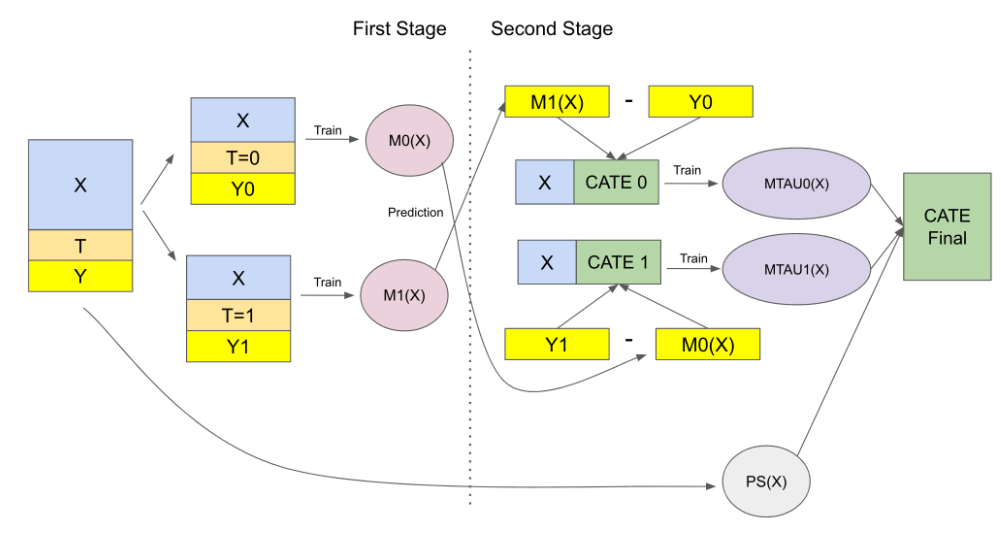

**My_understanding**

First, we split the dataset into two groups: those who received the treatment and those who did not. We train two separate models on these groups to predict the outcome based on the individuals’ features. Then, we use the model trained on the treatment group to predict the outcomes for the control group and the model trained on the control group to predict the outcomes for the treatment group. Next, we calculate the imputed treatment effects: for the treatment group, we subtract the control model’s predicted outcome from the observed outcome, and for the control group, we subtract the observed outcome from the treatment model’s predicted outcome. We then train two additional models to predict these imputed treatment effects based on the individuals’ features. We estimate the propensity score by training a model to predict the likelihood of belonging to the treatment or control group given the individual’s features. Finally, we estimate the Conditional Average Treatment Effect (CATE) for each individual by multiplying the propensity score by the predicted treatment effect from the control group’s model and adding one minus the propensity score multiplied by the predicted treatment effect from the treatment group’s model.

In [ ]:
## Manual calculation

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 1000
n_features = 5
X = np.random.randn(n_samples, n_features)  # Covariates
W = np.random.binomial(1, 0.5, n_samples)  # Binary treatment
# True CATE: treatment effect varies with X[:, 0]
true_cate = X[:, 0]
Y = X[:, 0] + W * true_cate + np.random.randn(n_samples) * 0.1  # Outcome

# Split data into training and test sets
X_train, X_test, W_train, W_test, Y_train, Y_test = train_test_split(
    X, W, Y, test_size=0.2, random_state=42
)

# Step 1: Fit outcome models for treatment and control groups
# Separate treatment and control data
mask_treated = W_train == 1
mask_control = W_train == 0
X_treated, Y_treated = X_train[mask_treated], Y_train[mask_treated]
X_control, Y_control = X_train[mask_control], Y_train[mask_control]

# Train outcome models
mu_1 = RandomForestRegressor(n_estimators=100, random_state=42)
mu_1.fit(X_treated, Y_treated)  # Model for treated group
mu_0 = RandomForestRegressor(n_estimators=100, random_state=42)
mu_0.fit(X_control, Y_control)  # Model for control group

# Step 2: Impute treatment effects
# For treated: D_i^1 = Y_i - mu_0(X_i)
D_treated = Y_treated - mu_0.predict(X_treated)
# For control: D_i^0 = mu_1(X_i) - Y_i
D_control = mu_1.predict(X_control) - Y_control

# Step 3: Fit CATE models
tau_1 = RandomForestRegressor(n_estimators=100, random_state=42)
tau_1.fit(X_treated, D_treated)  # Model for treated imputed effects
tau_0 = RandomForestRegressor(n_estimators=100, random_state=42)
tau_0.fit(X_control, D_control)  # Model for control imputed effects

# Step 4: Combine CATE estimates with propensity score weighting
# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X_train, W_train)
propensity_scores = propensity_model.predict_proba(X_test)[:, 1]

# Combine CATE estimates: tau(X) = g(X) * tau_0(X) + (1 - g(X)) * tau_1(X)
g = propensity_scores  # Use propensity scores as weights
cate_pred = g * tau_0.predict(X_test) + (1 - g) * tau_1.predict(X_test)

# Evaluate on test set (compare with true CATE)
true_cate_test = X_test[:, 0]
mse = np.mean((cate_pred - true_cate_test) ** 2)
print(f"Mean Squared Error of CATE estimate: {mse:.4f}")

# Optional: Print first few predicted vs true CATEs
results = pd.DataFrame({
    'True CATE': true_cate_test,
    'Predicted CATE': cate_pred
})
print("\nFirst 5 predicted vs true CATEs:")
print(results.head())

Mean Squared Error of CATE estimate: 0.0073

First 5 predicted vs true CATEs:
   True CATE  Predicted CATE
0  -0.184525       -0.214246
1  -0.850535       -0.750448
2   1.065172        1.012804
3   0.338553        0.319486
4  -0.819258       -0.808883


## R-Learners

R-learners are a type of meta-learner used in causal inference to estimate heterogeneous treatment effects, specifically the Conditional Average Treatment Effect (CATE), which is the expected difference in outcomes between treatment and control conditions conditional on covariates, \(\tau(X) = E[Y(1) - Y(0)|X]\). Introduced by Nie and Wager (2017) in the context of causal inference, R-learners are designed to address challenges in estimating CATE, particularly in observational studies where treatment assignment may be confounded. They are robust, flexible, and particularly effective when combined with machine learning methods. Below, I’ll explain R-learners in detail, comparing them to X-learners (since you previously asked about X-learners) and providing a clear, structured overview.

### What Are R-Learners?
R-learners (short for "Robinson-learners," named after a key insight from Robinson’s 1988 transformation) are a meta-learner framework that reformulates the CATE estimation problem into a single regression task by leveraging a residualized outcome approach. This approach accounts for both the main effects of covariates on the outcome and the propensity score (the probability of receiving treatment given covariates). R-learners are particularly effective in observational data settings, where treatment assignment is not random, and they can use any machine learning model to estimate CATE.

The core idea is to transform the observed data into a residualized form that isolates the treatment effect, then directly model the CATE as a function of covariates using a single regression model. This contrasts with other meta-learners like X-learners, which use multiple models and stages.

### How R-Learners Work
The R-learner is based on a reformulation of the causal inference problem inspired by Robinson’s decomposition. The algorithm proceeds in the following steps:

1. **Estimate Nuisance Functions**:
   - **Outcome Model**: Fit a model to estimate the expected outcome given covariates, \( m(X) = E[Y|X] \), across all individuals (ignoring treatment status). This can be done using any machine learning model (e.g., random forest, neural network).
   - **Propensity Score Model**: Fit a model to estimate the propensity score, \( e(X) = P(W=1|X) \), the probability of receiving the treatment given covariates \( X \). This is typically a classification model (e.g., logistic regression, random forest classifier).
   - These are called "nuisance functions" because they are intermediate steps, not the final goal.

2. **Compute Residualized Outcome**:
   - Transform the observed outcome \( Y_i \) and treatment \( W_i \) into a residualized form:
     \[
     \tilde{Y}_i = Y_i - m(X_i)
     \]
     \[
     \tilde{W}_i = W_i - e(X_i)
     \]
     where \( \tilde{Y}_i \) is the residualized outcome (observed outcome minus predicted outcome), and \( \tilde{W}_i \) is the residualized treatment (observed treatment minus propensity score).
   - This transformation is based on Robinson’s insight that the CATE can be expressed as:
     \[
     E[\tilde{Y}_i | X_i, \tilde{W}_i] = \tau(X_i) \cdot \tilde{W}_i
     \]
     This isolates the treatment effect by removing the main effects of covariates and treatment assignment bias.

3. **Estimate CATE**:
   - Fit a regression model to predict the residualized outcome \( \tilde{Y}_i \) using the residualized treatment \( \tilde{W}_i \) as the predictor, weighted by the inverse of the propensity score variance, \( 1 / [e(X_i)(1 - e(X_i))] \). In practice, this is often formulated as minimizing a loss function:
     \[
     \hat{\tau}(X) = \arg\min_{\tau} \sum_i \left[ \tilde{Y}_i - \tau(X_i) \tilde{W}_i \right]^2 \cdot \frac{1}{e(X_i)(1 - e(X_i))}
     \]
     where \( \tau(X) \) is the CATE function to be estimated.
   - The regression model can be any flexible machine learning model (e.g., random forest, gradient boosting) that predicts \( \tilde{Y}_i / \tilde{W}_i \) as a function of \( X_i \).

4. **Cross-Fitting (Optional but Recommended)**:
   - To avoid overfitting, R-learners often use cross-fitting. Split the data into \( K \) folds (e.g., 5-fold cross-validation). For each fold, estimate \( m(X) \) and \( e(X) \) using the other folds, then compute residuals and fit the CATE model on the held-out fold. This ensures that the nuisance functions and CATE estimation are independent.

### Key Features of R-Learners
- **Single Regression Task**: Unlike X-learners, which use multiple models (two outcome models and two CATE models), R-learners reduce CATE estimation to a single regression problem after residualization.
- **Robustness to Nuisance Functions**: R-learners are robust to misspecification of the nuisance functions \( m(X) \) and \( e(X) \) as long as they are estimated consistently, thanks to their use of orthogonalized residuals.
- **Propensity Score Weighting**: The weighting by \( 1 / [e(X_i)(1 - e(X_i))] \) stabilizes the estimation by giving more weight to observations where the propensity score is balanced (close to 0.5).
- **Flexibility**: R-learners can use any machine learning model for both nuisance functions and CATE estimation, making them adaptable to complex, non-linear relationships.

### Advantages of R-Learners
- **Simplicity**: By reducing CATE estimation to a single regression task, R-learners are conceptually simpler than multi-stage meta-learners like X-learners.
- **Robustness**: The residualization process makes R-learners less sensitive to biases in the outcome or propensity score models, especially when cross-fitting is used.
- **Efficiency**: R-learners can achieve good statistical properties (e.g., asymptotic normality) under weaker assumptions than other meta-learners, making them efficient for large datasets.
- **Handles Imbalanced Treatments**: The propensity score weighting helps address imbalanced treatment assignments, common in observational studies.

### Limitations of R-Learners
- **Dependence on Nuisance Functions**: While robust, the accuracy of R-learners still depends on reasonable estimates of \( m(X) \) and \( e(X) \). Poorly estimated nuisance functions can degrade performance.
- **Computational Cost**: Estimating nuisance functions and performing cross-fitting can be computationally intensive, especially with large datasets or complex models.
- **Propensity Score Challenges**: In regions where \( e(X) \) is close to 0 or 1 (near-deterministic treatment assignment), the weighting term \( 1 / [e(X)(1 - e(X))] \) can become large, leading to instability unless regularized.

### Comparison with X-Learners
Since you previously asked about X-learners, here’s a comparison to highlight similarities and differences:
- **Structure**:
  - **X-Learner**: Uses a three-stage process: (1) fit outcome models for treatment and control groups, (2) impute treatment effects, (3) fit CATE models for each group and combine them using propensity score weights.
  - **R-Learner**: Uses a two-stage process: (1) estimate nuisance functions (\( m(X) \), \( e(X) \)), (2) fit a single CATE model on residualized outcomes and treatments.
- **Number of Models**:
  - **X-Learner**: Requires four models (two outcome models, two CATE models) plus an optional propensity score model.
  - **R-Learner**: Requires three models (one outcome model, one propensity score model, one CATE model).
- **Propensity Score Use**:
  - **X-Learner**: Uses propensity scores to weight the combination of two CATE models.
  - **R-Learner**: Uses propensity scores to weight the residualized regression, integrating them directly into the loss function.
- **Robustness**:
  - **X-Learner**: Robust to imbalanced treatment groups by modeling treatment effects separately for each group.
  - **R-Learner**: Robust to misspecification of nuisance functions due to residualization and cross-fitting.
- **Use Case**:
  - **X-Learner**: Excels when treatment effects are highly heterogeneous or treatment groups are imbalanced.
  - **R-Learner**: Preferred when simplicity and statistical efficiency are priorities, especially in observational studies with confounding.

### Practical Considerations
- **When to Use R-Learners**: R-learners are well-suited for observational studies or randomized experiments where treatment effects vary across covariates, and you want a robust, single-model approach. They are particularly effective with large datasets and when cross-fitting is feasible.
- **Implementation**: R-learners can be implemented using standard machine learning libraries (e.g., scikit-learn, XGBoost). Libraries like `EconML` or `CausalML` in Python provide built-in support for R-learners with cross-fitting.
- **Evaluation**: Since true CATE is rarely known, performance can be assessed using cross-validation, sensitivity analyses, or simulation studies. In randomized experiments, you can compare to average treatment effects.

In [ ]:
## manual_calculation

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 1000
n_features = 5
X = np.random.randn(n_samples, n_features)
W = np.random.binomial(1, 0.5, n_samples)
true_cate = X[:, 0]
Y = X[:, 0] + W * true_cate + np.random.randn(n_samples) * 0.1

# Split data
X_train, X_test, W_train, W_test, Y_train, Y_test = train_test_split(
    X, W, Y, test_size=0.2, random_state=42
)

# Step 1: Estimate nuisance functions
# Outcome model: E[Y|X]
m = RandomForestRegressor(n_estimators=100, random_state=42)
m.fit(X_train, Y_train)
m_pred = m.predict(X_train)

# Propensity score: P(W=1|X)
e = LogisticRegression(random_state=42)
e.fit(X_train, W_train)
e_pred = e.predict_proba(X_train)[:, 1]

# Step 2: Compute residuals
Y_residual = Y_train - m_pred
W_residual = W_train - e_pred

# Step 3: Fit CATE model
# Weight by 1 / [e(X)(1 - e(X))]
weights = 1 / (e_pred * (1 - e_pred) + 1e-6)  # Add small constant for stability
tau = RandomForestRegressor(n_estimators=100, random_state=42)
# Regress Y_residual / W_residual ~ X
pseudo_outcome = Y_residual / (W_residual + 1e-6)  # Avoid division by zero
tau.fit(X_train, pseudo_outcome, sample_weight=weights)

# Predict CATE on test set
cate_pred = tau.predict(X_test)

# Evaluate
true_cate_test = X_test[:, 0]
mse = np.mean((cate_pred - true_cate_test) ** 2)
print(f"Mean Squared Error of CATE estimate: {mse:.4f}")

# Print first few predictions
results = pd.DataFrame({
    'True CATE': true_cate_test,
    'Predicted CATE': cate_pred
})
print("\nFirst 5 predicted vs true CATEs:")
print(results.head())

Mean Squared Error of CATE estimate: 0.4264

First 5 predicted vs true CATEs:
   True CATE  Predicted CATE
0  -0.184525       -0.077218
1  -0.850535       -0.334067
2   1.065172        0.391852
3   0.338553        0.153203
4  -0.819258       -0.318881
